<a href="https://colab.research.google.com/github/athiq-ahmed/Pytorch/blob/master/Captcha_recognition_using_PyTorch_(Convolutional_RNN_%2B_CTC_Loss).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Sep 12 16:35:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    225      0 --:--:-- --:--:-- --:--:--   225
100 8863k  100 8863k    0     0  6659k      0  0:00:01  0:00:01 --:--:-- 50.1M


In [3]:
!unzip -qq captcha_images_v2.zip

### Config.py

In [4]:
DATA_DIR = '/content/captcha_images_v2'
BATCH_SIZE = 8
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 75
NUM_WORKERS = 4
EPOCHS = 200
DEVICE = "cuda"

In [5]:
import glob
# glob.glob('/content/captcha_images_v2/*.png')

### Dataset.py

In [6]:
import albumentations # for augmentations
import torch
import numpy as np

from PIL import Image
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
class ClassificationDataset:
  def __init__(self, image_paths, targets, resize=None):
    self.image_paths = image_paths
    self.targets = targets
    self.resize = resize
    # self.aug = albumentations.Compose([albumentations.Normalize(always_apply=True)])

    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    self.aug = albumentations.Compose(
        [
            albumentations.Normalize(
                mean, std, max_pixel_value=255.0, always_apply=True
            )
        ]
    )
    
  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, item):
    image = Image.open(self.image_paths[item]).convert("RGB")
    targets = self.targets[item]

    if self.resize is not None:
      image = image.resize((self.resize[1], self.resize[0]), resample=Image.BILINEAR)

    image = np.array(image)
    augmented = self.aug(image=image)
    image = augmented["image"]
    image = np.transpose(image, (2,0,1)).astype(np.float32)

    return {
        "images": torch.tensor(image, dtype=torch.float),
        "targets": torch.tensor(targets, dtype=torch.long)
    }

### engine.py

In [8]:
from tqdm import tqdm
import torch

def train_fn(model, data_loader, optimizer):
  model.train()
  fin_loss = 0
  tk = tqdm(data_loader, total=len(data_loader))
  for data in tk:
    for k, v in data.items():
      data[k] = v.to(DEVICE)
    optimizer.zero_grad()
    _, loss = model(**data)
    loss.backward()
    optimizer.step()
    fin_loss += loss
  return fin_loss / len(data_loader)

def eval_fn(model, data_loader):
  model.eval()
  fin_loss = 0
  fin_preds = []
  with torch.no_grad():
    tk = tqdm(data_loader, total=len(data_loader))
    for data in tk:
      for k, v in data.items():
        data[k] = v.to(DEVICE)

      preds, loss = model(**data)
      fin_loss += loss
      fin_preds.append(preds)
    return fin_preds, fin_loss / len(data_loader)

### model.py

In [9]:
import torch
from torch import nn
from torch.nn import functional as F

class CaptchaModel(nn.Module):
  def __init__(self, num_chars):
    super(CaptchaModel, self).__init__()
    self.conv_1 = nn.Conv2d(3, 128, kernel_size=(3,3), padding=(1,1))
    self.max_pool_1 = nn.MaxPool2d(kernel_size=(2,2))
    self.conv_2 = nn.Conv2d(128, 64, kernel_size=(3,3), padding=(1,1))
    self.max_pool_2 = nn.MaxPool2d(kernel_size=(2,2))

    self.linear_1 = nn.Linear(1152, 64)
    self.drop_1= nn.Dropout(0.2)

    self.gru = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25)
    self.output = nn.Linear(64, num_chars+1)

  def forward(self, images, targets=None):
    bs, c, h, w = images.size()
    # print(bs, c, h, w)
    x = F.relu(self.conv_1(images))
    # print(x.size())
    x = self.max_pool_1(x)
    # print(x.size())
    x = F.relu(self.conv_2(x))
    # print(x.size())
    x = self.max_pool_2(x) # [1, 64, 18, 75]
    # print(x.size())
    x = x.permute(0,3,1,2) # [1, 75, 64, 18]
    # print(x.size())
    x = x.view(bs, x.size(1), -1)
    # print(x.size()) #[1, 75, 1152]
    x = self.linear_1(x)
    x = self.drop_1(x)
    # print(x.size())
    x, _ = self.gru(x)
    # print(x.size())
    x = self.output(x)
    # print(x.size())
    x = x.permute(1,0,2)
    # print(x.size())

    if targets is not None:
      log_softmax_values = F.log_softmax(x, 2)
      input_lengths = torch.full(size=(bs,),fill_value=log_softmax_values.size(0),dtype=torch.int32)
      # print(input_lengths)
      target_lengths = torch.full(size=(bs,),fill_value=targets.size(1),dtype=torch.int32)
      # print(target_lengths)
      loss = nn.CTCLoss(blank=0)(log_softmax_values, targets, input_lengths, target_lengths)
      return x, loss

    return x, None

if __name__ == "__main__":
  cm = CaptchaModel(19)
  img = torch.rand(1,3,75,300)
  target = torch.randint(1,20,(1,5))
  x, loss = cm(img, target)


### train.py

In [10]:
import os
import glob
import torch
import numpy as np

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics

from pprint import pprint

def decode_predictions(preds, encoder):
  preds = preds.permute(1, 0 ,2)
  preds = torch.softmax(preds, 2)
  preds = torch.argmax(preds, 2)
  preds = preds.detach().cpu().numpy()
  cap_preds = []
  for j in range(preds.shape[0]):
    temp = []
    for k in preds[j, :]:
      k = k-1
      if k == -1:
        temp.append("`")
      else:
        temp.append(encoder.inverse_transform([k])[0])
    tp = "".join(temp)
    cap_preds.append(tp)
    return cap_preds


def run_traning():
  image_files = glob.glob('/content/captcha_images_v2/*.png')
  targets_orig = [x.split('/')[-1][:4] for x in image_files]  # "'../../../abcd.png"
  targets = [[c for c in x] for x in targets_orig]  # abcd --> [a, b, c, d]
  targets_flat = [c for clist in targets for c in clist]

  lbl_enc = preprocessing.LabelEncoder()
  lbl_enc.fit(targets_flat)
  targets_enc = [lbl_enc.transform(x) for x in targets]
  targets_enc = np.array(targets_enc) + 1


  (train_imgs, test_imgs, train_targets, test_targets, train_orig_targets, test_orig_targets) = \
  model_selection.train_test_split(image_files, targets_enc, targets_orig, test_size=0.1, random_state=42)

  train_dataset = ClassificationDataset(image_paths=train_imgs, targets=train_targets, resize=(IMAGE_HEIGHT, IMAGE_WIDTH))
  test_dataset = ClassificationDataset(image_paths=test_imgs, targets=test_targets, resize=(IMAGE_HEIGHT, IMAGE_WIDTH))

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

  model = CaptchaModel(num_chars=len(lbl_enc.classes_))
  model.to(DEVICE)

  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=5, verbose=True)

  for epoch in range(EPOCHS):
    train_loss = train_fn(model, train_loader, optimizer)
    valid_preds, valid_loss = eval_fn(model, test_loader)

    valid_cap_preds=[]
    for vp in valid_preds:
      current_preds = decode_predictions(vp, lbl_enc)
      valid_cap_preds.extend(current_preds)
    pprint(list(zip(test_orig_targets, valid_cap_preds))[6:10])
    print(f'EPOCH:{epoch}, train_loss={train_loss}, valid_loss={valid_loss}')

  # print(targets)
  # print('*'*100)
  # print(np.unique(targets_flat))
  # print('*'*100)
  # print(targets_enc)
  # print('*'*100)
  # print(len(lbl_enc.classes_))


run_traning()

  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:0, train_loss=9.064306259155273, valid_loss=3.4631714820861816


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:1, train_loss=3.441807985305786, valid_loss=3.411414384841919


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:2, train_loss=3.3925743103027344, valid_loss=3.3919591903686523


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:3, train_loss=3.3756263256073, valid_loss=3.3799664974212646


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:4, train_loss=3.364619493484497, valid_loss=3.369905710220337


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:5, train_loss=3.3570895195007324, valid_loss=3.3637845516204834


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:6, train_loss=3.348822832107544, valid_loss=3.3556461334228516


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:7, train_loss=3.344961166381836, valid_loss=3.3531057834625244


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:8, train_loss=3.342478036880493, valid_loss=3.350661516189575


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:9, train_loss=3.3390097618103027, valid_loss=3.350121259689331


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:10, train_loss=3.3369863033294678, valid_loss=3.351682424545288


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:11, train_loss=3.3355672359466553, valid_loss=3.346255302429199


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:12, train_loss=3.3358213901519775, valid_loss=3.342766761779785


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:13, train_loss=3.334148645401001, valid_loss=3.346290111541748


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:14, train_loss=3.333535671234131, valid_loss=3.346952199935913


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:15, train_loss=3.3332722187042236, valid_loss=3.347399950027466


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:16, train_loss=3.3322579860687256, valid_loss=3.346393346786499


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:17, train_loss=3.3332133293151855, valid_loss=3.3461954593658447


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:18, train_loss=3.331979513168335, valid_loss=3.347816228866577


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:19, train_loss=3.3336026668548584, valid_loss=3.343001365661621


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:20, train_loss=3.3339180946350098, valid_loss=3.3449790477752686


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:21, train_loss=3.3322243690490723, valid_loss=3.3435144424438477


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:22, train_loss=3.332284688949585, valid_loss=3.3488361835479736


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:23, train_loss=3.333371639251709, valid_loss=3.354466199874878


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:24, train_loss=3.3320276737213135, valid_loss=3.3503217697143555


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:25, train_loss=3.3318943977355957, valid_loss=3.348911762237549


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:26, train_loss=3.3339502811431885, valid_loss=3.3542182445526123


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:27, train_loss=3.3325395584106445, valid_loss=3.357473134994507


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:28, train_loss=3.332948684692383, valid_loss=3.3526852130889893


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:29, train_loss=3.332275629043579, valid_loss=3.3510384559631348


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:30, train_loss=3.331430435180664, valid_loss=3.35343599319458


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:31, train_loss=3.3294379711151123, valid_loss=3.3597216606140137


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:32, train_loss=3.324613332748413, valid_loss=3.326122760772705


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:33, train_loss=3.3057591915130615, valid_loss=3.2724077701568604


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:34, train_loss=3.2537777423858643, valid_loss=3.255841016769409


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '````````````````````````````````````````````f``````````````````````````````'),
 ('5mff',
  '``````````````````````````g````````````````````````````````````````````````')]
EPOCH:35, train_loss=3.1360983848571777, valid_loss=3.05312180519104


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '`````````````````b``````````````````````````d``````````````````````````````'),
 ('5mff',
  '``````````````````````````g````````````````````````````````````````````````')]
EPOCH:36, train_loss=2.9671905040740967, valid_loss=2.8340377807617188


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '`````````````````````````````b`````````````````````````````````````````````'),
 ('cdmn',
  '`````````````````b``````````````````````````b``````````````````````````````'),
 ('5mff',
  '``````````````````````````g````````````````````````````````````````````````')]
EPOCH:37, train_loss=2.793133497238159, valid_loss=2.6876838207244873


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '`````````````````````````````f`````````````````````````````````````````````'),
 ('cdmn',
  '`````````````````b``````````````````````````f``````````````````````````````'),
 ('5mff',
  '``````````````````````````p````````````````````````````````````````````````')]
EPOCH:38, train_loss=2.6043319702148438, valid_loss=2.502375841140747


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '````````````````2````````````f`````````````````````````````````````````````'),
 ('cdmn',
  '`````````````````f`````````````````````````````````````````````````````````'),
 ('5mff',
  '``````````````````````````g````````````````````````````````````````````````')]
EPOCH:39, train_loss=2.4396088123321533, valid_loss=2.3596606254577637


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '`````````````````````````````6`````````````````````````````````````````````'),
 ('pe4x',
  '````````````````2````````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``````````````````````````f``````````````````````````````'),
 ('5mff',
  '``````````````````````````g`````````````````````y``````````````````````````')]
EPOCH:40, train_loss=2.274582624435425, valid_loss=2.089601993560791


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '`````````````````````````````6`````````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2````````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````````````7``d``````````````````````````````'),
 ('5mff',
  '``````````````````````````g`````````````````````y``````````````````````````')]
EPOCH:41, train_loss=2.0891194343566895, valid_loss=1.9476836919784546


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '`````````````````````````````6`````````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2````````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````````````7`````````````````````````````````'),
 ('5mff',
  '``````````````````````````g`````````````````````y``````````````````````````')]
EPOCH:42, train_loss=1.921986699104309, valid_loss=1.7585841417312622


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '`````````````````````````````6`````````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``````````n````n```````7``d``````````````````````````````'),
 ('5mff',
  '``````````````````````````g`````````````````````y``````````````````````````')]
EPOCH:43, train_loss=1.7854808568954468, valid_loss=1.7105411291122437


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '`````````````````````````````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4`````````````````````````````````````````````````````````'),
 ('5mff',
  '``````````````````````````g`````````````````````y``````````````````````````')]
EPOCH:44, train_loss=1.607208251953125, valid_loss=1.3785932064056396


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '`````````````````````````````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``````````n``````````````````````````````````````````````'),
 ('5mff',
  '``````````````````````````g````````````````````````````````````````````````')]
EPOCH:45, train_loss=1.4240562915802002, valid_loss=1.2569738626480103


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '`````````````````````````````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``````````n````````````7`````````````````````````````````'),
 ('5mff',
  '``````````````````````````g`````````````````````y``````````````````````````')]
EPOCH:46, train_loss=1.3113586902618408, valid_loss=1.1744754314422607


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '`````````````````````````````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4`````````````````````````````````````````````````````````'),
 ('5mff',
  '``````````````````````````g`````````````````````y``````````````````````````')]
EPOCH:47, train_loss=1.2066938877105713, valid_loss=0.9962602853775024


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '`````````````````````````````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``x```````n``````````````````````````````````````````````'),
 ('5mff',
  '``````````````````````````g``````````````x``````y``````````````````````````')]
EPOCH:48, train_loss=1.0919901132583618, valid_loss=0.951413094997406


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '`````````````````````````````6````````````88```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``x```````n````````````7`````````````````````````````````'),
 ('5mff',
  '``````````````````````````g``````````````x``````y``````````````````````````')]
EPOCH:49, train_loss=1.0159507989883423, valid_loss=0.9207040667533875


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '`````````````````````````````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``x```````n````````````7`````````````````````````````````'),
 ('5mff',
  '``````````````````````````g``````````````x``````y``````````````````````````')]
EPOCH:50, train_loss=0.9264146685600281, valid_loss=0.8944715857505798


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '`````````````````````````````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``x```````n``````````````````````````````````````````````'),
 ('5mff',
  '``````````````````````````g``````````````x``````y``````````````````````````')]
EPOCH:51, train_loss=0.8705822229385376, valid_loss=0.7260562777519226


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '`````````````````````````````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``x```````n````````````7`````````````````````````````````'),
 ('5mff',
  '``````````````````````````g``````````````x``````y``````````````````````````')]
EPOCH:52, train_loss=0.8092842698097229, valid_loss=0.6698092222213745


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '`````````````````````````````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``x```````n``````````````````````````````````````````````'),
 ('5mff',
  '``````````````````````````g``````````````x`````````````````````````````````')]
EPOCH:53, train_loss=0.7692465782165527, valid_loss=0.6181773543357849


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````c`````````````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '``````````````````````````g``````````````x`````````````````````````````````')]
EPOCH:54, train_loss=0.6975522041320801, valid_loss=0.6254374384880066


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````````````6````````````88```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x``````y``````````````````````````')]
EPOCH:55, train_loss=0.6393101811408997, valid_loss=0.572955310344696


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````````````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g``````````````x`````````````````````````````````')]
EPOCH:56, train_loss=0.594635009765625, valid_loss=0.5169187784194946


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:57, train_loss=0.5634832978248596, valid_loss=0.4929293692111969


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c`````````xx`````````````````````````````````')]
EPOCH:58, train_loss=0.5291851758956909, valid_loss=0.5690992474555969


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:59, train_loss=0.5057260394096375, valid_loss=0.49229761958122253


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````````````6````````````88```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g``````````````x`````````````````````````````````')]
EPOCH:60, train_loss=0.4893595278263092, valid_loss=0.5003702044487


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6````````````88```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:61, train_loss=0.4564078152179718, valid_loss=0.47779616713523865


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:62, train_loss=0.43804189562797546, valid_loss=0.49743834137916565


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g``````````````x`````````````````````````````````')]
EPOCH:63, train_loss=0.4558844268321991, valid_loss=0.46884438395500183


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6````````````88```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c`````````xx``````y``````````````````````````')]
EPOCH:64, train_loss=0.4096602201461792, valid_loss=0.47198766469955444


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:65, train_loss=0.4133881628513336, valid_loss=0.4247286319732666


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:66, train_loss=0.36200496554374695, valid_loss=0.40926769375801086


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6````````````88```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:67, train_loss=0.3653714954853058, valid_loss=0.42564767599105835


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:68, train_loss=0.361423522233963, valid_loss=0.415022611618042


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c`````````xx`````````````````````````````````')]
EPOCH:69, train_loss=0.3633493185043335, valid_loss=0.4503154158592224


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c`````````xx``````y``````````````````````````')]
EPOCH:70, train_loss=0.3416365683078766, valid_loss=0.5015771985054016


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6````````````88```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:71, train_loss=0.33986926078796387, valid_loss=0.4975385069847107


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:72, train_loss=0.3400428295135498, valid_loss=0.39214378595352173


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:73, train_loss=0.3180444538593292, valid_loss=0.3738512694835663


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6````````````88```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:74, train_loss=0.29547441005706787, valid_loss=0.44093427062034607


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:75, train_loss=0.295564204454422, valid_loss=0.49461811780929565


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c``````````x``````y``````````````````````````')]
EPOCH:76, train_loss=0.2807520925998688, valid_loss=0.4038727581501007


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c`````````xx`````````````````````````````````')]
EPOCH:77, train_loss=0.2619994878768921, valid_loss=0.3830658197402954


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c`````````xx`````````````````````````````````')]
EPOCH:78, train_loss=0.29891929030418396, valid_loss=0.3944419026374817


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '``````````````````````````g```c``````````x`````````````````````````````````')]
EPOCH:79, train_loss=0.27802160382270813, valid_loss=0.33921077847480774


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:80, train_loss=0.2528435289859772, valid_loss=0.41056063771247864


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c``````````x`````````````````````````````````')]
EPOCH:81, train_loss=0.2432023137807846, valid_loss=0.4988079369068146


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6````````````88```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c`````````xx``````y``````````````````````````')]
EPOCH:82, train_loss=0.24210454523563385, valid_loss=0.5204741358757019


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c`````````xx`````````````````````````````````')]
EPOCH:83, train_loss=0.28621646761894226, valid_loss=0.3998779356479645


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '``````````````````````````g```c``````````x`````````````````````````````````')]
EPOCH:84, train_loss=0.21942515671253204, valid_loss=0.4143872857093811


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c`````````xx`````````````````````````````````')]
EPOCH:85, train_loss=0.23114104568958282, valid_loss=0.4302595853805542


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c``````````x``````y``````````````````````````')]
EPOCH:86, train_loss=0.21289239823818207, valid_loss=0.4286303222179413


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c``````````x`````````````````````````````````')]
EPOCH:87, train_loss=0.22387583553791046, valid_loss=0.4681898057460785


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:88, train_loss=0.2158789485692978, valid_loss=0.4776562452316284


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c``````````x`````````````````````````````````')]
EPOCH:89, train_loss=0.20205587148666382, valid_loss=0.4016698896884918


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '``````````````````````````g```c``````````x`````````````````````````````````')]
EPOCH:90, train_loss=0.2088058888912201, valid_loss=0.4005286395549774


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '``````````````````````````g```c``````````x`````````````````````````````````')]
EPOCH:91, train_loss=0.20611388981342316, valid_loss=0.4456869661808014


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c``````````x`````````````````````````````````')]
EPOCH:92, train_loss=0.1802796870470047, valid_loss=0.44135892391204834


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c``````````x`````````````````````````````````')]
EPOCH:93, train_loss=0.1902761310338974, valid_loss=0.36539721488952637


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x``````y``````````````````````````')]
EPOCH:94, train_loss=0.18916864693164825, valid_loss=0.42229342460632324


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c``````````x``````y``````````````````````````')]
EPOCH:95, train_loss=0.18448716402053833, valid_loss=0.4689757525920868


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c``````````x`````````````````````````````````')]
EPOCH:96, train_loss=0.19809111952781677, valid_loss=0.4064314067363739


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c`````````xx`````````````````````````````````')]
EPOCH:97, train_loss=0.20208849012851715, valid_loss=0.43293023109436035


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c``````````x`````````````````````````````````')]
EPOCH:98, train_loss=0.16609424352645874, valid_loss=0.40382423996925354


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c``````````x`````````````````````````````````')]
EPOCH:99, train_loss=0.16950930655002594, valid_loss=0.36103448271751404


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c`````````xx``````y``````````````````````````')]
EPOCH:100, train_loss=0.17904937267303467, valid_loss=0.4389456510543823


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g``````````````x`````````````````````````````````')]
EPOCH:101, train_loss=0.18333223462104797, valid_loss=0.439334899187088


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c``````````x``````y``````````````````````````')]
EPOCH:102, train_loss=0.17408917844295502, valid_loss=0.41335606575012207


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c``````````x`````````````````````````````````')]
EPOCH:103, train_loss=0.1798543781042099, valid_loss=0.4020531475543976


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6````````````88```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c`````````xx`````````````````````````````````')]
EPOCH:104, train_loss=0.14513902366161346, valid_loss=0.5679994821548462


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c`````````xx`````````````````````````````````')]
EPOCH:105, train_loss=0.156863734126091, valid_loss=0.42987361550331116


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c`````````xx`````````````````````````````````')]
EPOCH:106, train_loss=0.15005965530872345, valid_loss=0.481844961643219


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g`````````````xx`````````````````````````````````')]
EPOCH:107, train_loss=0.14750806987285614, valid_loss=0.39411693811416626


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6````````````38```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c`````````xx``````y``````````````````````````')]
EPOCH:108, train_loss=0.15310026705265045, valid_loss=0.46107685565948486


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g`````````````xx`````````````````````````````````')]
EPOCH:109, train_loss=0.17280463874340057, valid_loss=0.4182700216770172


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g``````````````x`````````````````````````````````')]
EPOCH:110, train_loss=0.1420065313577652, valid_loss=0.46648290753364563


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c`````````xx``````y``````````````````````````')]
EPOCH:111, train_loss=0.14087536931037903, valid_loss=0.5837300419807434


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``c```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:112, train_loss=0.17235024273395538, valid_loss=0.3945634961128235


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:113, train_loss=0.1417492926120758, valid_loss=0.4547993838787079


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:114, train_loss=0.14003203809261322, valid_loss=0.41914770007133484


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c`````````xx`````````````````````````````````')]
EPOCH:115, train_loss=0.13845905661582947, valid_loss=0.41432052850723267


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c``````````x`````````````````````````````````')]
EPOCH:116, train_loss=0.14004424214363098, valid_loss=0.453924298286438


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:117, train_loss=0.15012921392917633, valid_loss=0.4858335256576538


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c`````````xx``````y``````````````````````````')]
EPOCH:118, train_loss=0.1265510618686676, valid_loss=0.3963097333908081


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c`````````xx``````y``````````````````````````')]
EPOCH:119, train_loss=0.12931807339191437, valid_loss=0.46175506711006165


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c`````````xx`````````````````````````````````')]
EPOCH:120, train_loss=0.1198192909359932, valid_loss=0.4157300591468811


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c``````````x`````````````````````````````````')]
EPOCH:121, train_loss=0.12081639468669891, valid_loss=0.46545320749282837


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6````````````38```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g`````````````xx``````y``````````````````````````')]
EPOCH:122, train_loss=0.14650842547416687, valid_loss=0.47950708866119385


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g``````````````x`````````````````````````````````')]
EPOCH:123, train_loss=0.16431961953639984, valid_loss=0.48622870445251465


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``c```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c`````````xx``````y``````````````````````````')]
EPOCH:124, train_loss=0.1377861499786377, valid_loss=0.4439311623573303


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c`````````xx``````y``````````````````````````')]
EPOCH:125, train_loss=0.12489300966262817, valid_loss=0.4027892053127289


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6````````````88```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c`````````xx`````````````````````````````````')]
EPOCH:126, train_loss=0.11477094888687134, valid_loss=0.5191691517829895


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:127, train_loss=0.14845214784145355, valid_loss=0.39991623163223267


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x``````y``````````````````````````')]
EPOCH:128, train_loss=0.1256895810365677, valid_loss=0.4352371394634247


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``c```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:129, train_loss=0.11160719394683838, valid_loss=0.45810991525650024


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c`````````xx``````y``````````````````````````')]
EPOCH:130, train_loss=0.11459945142269135, valid_loss=0.4351014196872711


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g`````````````xx`````````````````````````````````')]
EPOCH:131, train_loss=0.11609834432601929, valid_loss=0.4415743052959442


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g``````````````x`````````````````````````````````')]
EPOCH:132, train_loss=0.12749218940734863, valid_loss=0.3936132490634918


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``c```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g``````````````x`````````````````````````````````')]
EPOCH:133, train_loss=0.12162063270807266, valid_loss=0.47153815627098083


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c`````````xx``````y``````````````````````````')]
EPOCH:134, train_loss=0.13007748126983643, valid_loss=0.4210067391395569


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c`````````xx`````````````````````````````````')]
EPOCH:135, train_loss=0.11431144177913666, valid_loss=0.3960244655609131


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g``````````````x``````y``````````````````````````')]
EPOCH:136, train_loss=0.11956664174795151, valid_loss=0.3910522162914276


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``c```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c`````````xx``````y``````````````````````````')]
EPOCH:137, train_loss=0.13308845460414886, valid_loss=0.5175595283508301


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c`````````xx`````````````````````````````````')]
EPOCH:138, train_loss=0.13413485884666443, valid_loss=0.45368245244026184


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:139, train_loss=0.11470016092061996, valid_loss=0.4208155870437622


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x``````y``````````````````````````')]
EPOCH:140, train_loss=0.12492009997367859, valid_loss=0.3976551592350006


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``c```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c``````````x``````y``````````````````````````')]
EPOCH:141, train_loss=0.10155840963125229, valid_loss=0.46805399656295776


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``c```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c``````````x``````y``````````````````````````')]
EPOCH:142, train_loss=0.09466598182916641, valid_loss=0.4429953396320343


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:143, train_loss=0.08805333822965622, valid_loss=0.422585129737854


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``c```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:144, train_loss=0.09646134078502655, valid_loss=0.3908652663230896


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:145, train_loss=0.08697868883609772, valid_loss=0.4683094620704651


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c`````````xx``````y``````````````````````````')]
EPOCH:146, train_loss=0.12469007074832916, valid_loss=0.40421077609062195


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c``````````x`````````````````````````````````')]
EPOCH:147, train_loss=0.0975763127207756, valid_loss=0.398149311542511


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``c```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:148, train_loss=0.10086096078157425, valid_loss=0.3959313631057739


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c``````````x`````````````````````````````````')]
EPOCH:149, train_loss=0.10187959671020508, valid_loss=0.4013875722885132


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c``````````x`````````````````````````````````')]
EPOCH:150, train_loss=0.08193063735961914, valid_loss=0.4312347173690796


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c`````````xx`````````````````````````````````')]
EPOCH:151, train_loss=0.11214718222618103, valid_loss=0.48052918910980225


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g`````````````xx`````````````````````````````````')]
EPOCH:152, train_loss=0.11262659728527069, valid_loss=0.49164941906929016


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g``````````````x`````````````````````````````````')]
EPOCH:153, train_loss=0.10408035665750504, valid_loss=0.429434210062027


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``c```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c``````````x`````````````````````````````````')]
EPOCH:154, train_loss=0.09631860256195068, valid_loss=0.37888509035110474


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``c```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c`````````xx``````y``````````````````````````')]
EPOCH:155, train_loss=0.08863122761249542, valid_loss=0.42698100209236145


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g``````````````x``````y``````````````````````````')]
EPOCH:156, train_loss=0.08380719274282455, valid_loss=0.41935208439826965


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``c```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g``````````````x``````y``````````````````````````')]
EPOCH:157, train_loss=0.08993127197027206, valid_loss=0.39620697498321533


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x``````y``````````````````````````')]
EPOCH:158, train_loss=0.07494034618139267, valid_loss=0.440228670835495


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x``````y``````````````````````````')]
EPOCH:159, train_loss=0.07758969813585281, valid_loss=0.4148710072040558


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`nm````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c`````````xx``````y``````````````````````````')]
EPOCH:160, train_loss=0.0873340591788292, valid_loss=0.6374379992485046


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:161, train_loss=0.10634613782167435, valid_loss=0.4647049605846405


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6````````````88```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c`````````xx`````````````````````````````````')]
EPOCH:162, train_loss=0.13119730353355408, valid_loss=0.4555472135543823


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x``````y``````````````````````````')]
EPOCH:163, train_loss=0.11088774353265762, valid_loss=0.569608747959137


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:164, train_loss=0.09568830579519272, valid_loss=0.4689410328865051


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6````````````88```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c`````````xx``````y``````````````````````````')]
EPOCH:165, train_loss=0.07955338805913925, valid_loss=0.5133443474769592


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``c```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c`````````xx``````y``````````````````````````')]
EPOCH:166, train_loss=0.07100015878677368, valid_loss=0.5048737525939941


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:167, train_loss=0.08799421042203903, valid_loss=0.5262311100959778


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6````````````38```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c`````````xx``````y``````````````````````````')]
EPOCH:168, train_loss=0.08455964177846909, valid_loss=0.6044710278511047


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c`````````xx`````````````````````````````````')]
EPOCH:169, train_loss=0.08870105445384979, valid_loss=0.46099573373794556


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c`````````xx``````y``````````````````````````')]
EPOCH:170, train_loss=0.07286762446165085, valid_loss=0.4785939157009125


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g`````````````xx``````y``````````````````````````')]
EPOCH:171, train_loss=0.07857707887887955, valid_loss=0.5492509007453918


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c``````````x`````````````````````````````````')]
EPOCH:172, train_loss=0.0935945063829422, valid_loss=0.5178757905960083


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:173, train_loss=0.08603240549564362, valid_loss=0.44971662759780884


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6````````````88```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c`````````xx``````y``````````````````````````')]
EPOCH:174, train_loss=0.09241920709609985, valid_loss=0.620276689529419


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c``````````x`````````````````````````````````')]
EPOCH:175, train_loss=0.09425636380910873, valid_loss=0.4495754539966583


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6````````````88```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g``````````````x`````````````````````````````````')]
EPOCH:176, train_loss=0.11015278846025467, valid_loss=0.45223915576934814


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``c```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g``````````````x`````````````````````````````````')]
EPOCH:177, train_loss=0.10491201281547546, valid_loss=0.46442723274230957


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``c```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x``````y``````````````````````````')]
EPOCH:178, train_loss=0.0738234892487526, valid_loss=0.47063666582107544


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``c```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c``````````x``````y``````````````````````````')]
EPOCH:179, train_loss=0.07067419588565826, valid_loss=0.4769844710826874


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c``````````x``````y``````````````````````````')]
EPOCH:180, train_loss=0.06264244019985199, valid_loss=0.5381174087524414


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g``````````````x``````y``````````````````````````')]
EPOCH:181, train_loss=0.06205977872014046, valid_loss=0.5071983337402344


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c``````````x``````y``````````````````````````')]
EPOCH:182, train_loss=0.05498476326465607, valid_loss=0.4965924024581909


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6````````````88```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c``````````x`````````````````````````````````')]
EPOCH:183, train_loss=0.06547760963439941, valid_loss=0.6011123061180115


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````c````g```c`````````xx`````````````````````````````````')]
EPOCH:184, train_loss=0.11395619809627533, valid_loss=0.5053368806838989


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6````````````38```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c`````````xx``````y``````````````````````````')]
EPOCH:185, train_loss=0.08708348125219345, valid_loss=0.5519719123840332


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c``````````x``````y``````````````````````````')]
EPOCH:186, train_loss=0.07270798832178116, valid_loss=0.4758736491203308


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``c```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:187, train_loss=0.06700699776411057, valid_loss=0.4869881868362427


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c`````````xx``````y``````````````````````````')]
EPOCH:188, train_loss=0.06512930244207382, valid_loss=0.6076323390007019


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``c```````n````````````7`````````````````````````````````'),
 ('5mff',
  '``````````````````````````g```c``````````x`````````````````````````````````')]
EPOCH:189, train_loss=0.08163172006607056, valid_loss=0.5756699442863464


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``c```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c``````````x`````````````````````````````````')]
EPOCH:190, train_loss=0.08493906259536743, valid_loss=0.4873144030570984


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c``````````x`````````````````````````````````')]
EPOCH:191, train_loss=0.06274048984050751, valid_loss=0.6050735116004944


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c`````````xx``````y``````````````````````````')]
EPOCH:192, train_loss=0.0632513165473938, valid_loss=0.5264784693717957


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:193, train_loss=0.06653949618339539, valid_loss=0.5258058309555054


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c``````````x``````y``````````````````````````')]
EPOCH:194, train_loss=0.059790726751089096, valid_loss=0.6883966326713562


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c`````````xx`````````````````````````````````')]
EPOCH:195, train_loss=0.08071333914995193, valid_loss=0.5665099620819092


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c`````````xx``````y``````````````````````````')]
EPOCH:196, train_loss=0.06045494228601456, valid_loss=0.5112912654876709


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x``````````g```c``````````x`````````````````````````````````')]
EPOCH:197, train_loss=0.057194121181964874, valid_loss=0.4780619442462921


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c``````````x`````````````````````````````````')]
EPOCH:198, train_loss=0.0663364827632904, valid_loss=0.5773308873176575


100%|██████████| 13/13 [00:00<00:00, 30.70it/s]

[('gc27',
  '```````````````x`````c```````6`````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22`n`````````f`````````2``6````````````````````````````````'),
 ('cdmn',
  '`````````````````4``e```````n````````````7`````````````````````````````````'),
 ('5mff',
  '```````````````x`````g````g```c``````````x``````y``````````````````````````')]
EPOCH:199, train_loss=0.09337785094976425, valid_loss=0.5470633506774902


### view.py

In [11]:
import os
import glob
import torch
import numpy as np

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

image_files = glob.glob('/content/captcha_images_v2/*.png')
targets_orig = [x.split('/')[-1][:4] for x in image_files]  # "'../../../abcd.png"
targets = [[c for c in x] for x in targets_orig]  # abcd --> [a, b, c, d]
targets_flat = [c for clist in targets for c in clist]

lbl_enc = preprocessing.LabelEncoder()
lbl_enc.fit(targets_flat)
targets_enc = [lbl_enc.transform(x) for x in targets]
targets_enc = np.array(targets_enc) + 1


(train_imgs, test_imgs, train_targets, test_targets, train_orig_targets, test_orig_targets) = \
model_selection.train_test_split(image_files, targets_enc, targets_orig, test_size=0.1, random_state=42)

train_dataset = ClassificationDataset(image_paths=train_imgs, targets=train_targets, resize=(IMAGE_HEIGHT, IMAGE_WIDTH))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


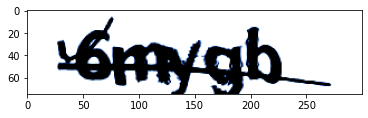

In [12]:
# train_dataset[0]
npimg = train_dataset[200]["images"].numpy()
# npimg
# npimg.shape
# np.transpose(npimg, (1,2,0)).shape
plt.imshow(np.transpose(npimg, (1,2,0)))